In [1]:
import os
import copy
import random
import cv2
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from PIL import Image
from glob import glob


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter


In [2]:
data_dir = "../data/raw/airlinersnet/"

In [3]:
def get_optimizer(model, lr):
    return torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


def get_loss_function():
    return nn.NLLLoss()

In [4]:
def load_data(data_dir):
    data_dir = data_dir
    train_dir = data_dir + 'train'
    test_dir = data_dir + 'test'
    valid_dir = data_dir + 'valid'

    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(240),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406 ], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid', 'test']}

    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=10, shuffle=True, num_workers=4) for x in ['train', 'valid', 'test']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test', 'valid']}

    class_names = image_datasets['train'].classes
    print(dataloaders)
    print(dataset_sizes)
    print(image_datasets)
    return dataloaders, dataset_sizes, image_datasets

In [5]:
def initialize_model(model_name, dropout,num_classes, hidden_layer, lr, device):

    if model_name == "densenet":
        model = models.densenet121(pretrained=True)
        input_size = 1024
    
    elif model_name == "vgg":
        model = models.vgg11_bn(pretrained=True)
        input_size = 25088
    
    elif model_name == "alexnet":
        model = models.alexnet(pretrained = True)
        input_size = 9216
    
    else:
        print('Invalid model name')
    
    for param in model.parameters():
        param.requires_grad = False

    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(input_size, hidden_layer)),
        ('relu', nn.ReLU()),
        ('dropout', nn.Dropout(dropout)),
        ('fc2', nn.Linear(hidden_layer, num_classes)),
        ('output', nn.LogSoftmax(dim=1))
    ]))

    model.classifier = classifier
    criterion = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)
    model.to(device)

    return model

In [6]:
def train_model(model, dataloaders,dataset_sizes, criterion, optimizer, scheduler, num_epochs, device):
    since = time.time()
    writer = SummaryWriter()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        print('-' * 10)

        # Train and validation phase for each of the epoch
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() # zero parameter gradients

                # Forward feed
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward and optimize only while training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss:{:.4f} Accuracy:{:.4f}'.format(phase, epoch_loss, epoch_acc))
            writer.add_scalar("Train/Loss", epoch_loss, epoch)
            writer.add_scalar("Train/Accuracy", epoch_acc, epoch)

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m and {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validation accuracy: {:.4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:

def save_checkpoint(checkpoint_path, arch, image_datasets, model, optimizer,num_epochs, lr, dropout, hidden_layer):
    if checkpoint_path is '':
        save_path = f'./checkpoint-{arch}.pth'
    else:
        save_path = save_dir + f'/checkpoint-{arch}.pth'
        
    model.class_to_idx = image_datasets['train'].class_to_idx
    model.cpu()
    torch.save({
        'model':model,
        'hidden_layer':hidden_layer,
        'lr':lr,
        'num_epochs':num_epochs,
        'dropout':dropout,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'class_to_idx':model.class_to_idx}, save_path)

def load_checkpoint(checkpoint_path):
    # Load the saved file
    checkpoint = torch.load(checkpoint_path)
    model = checkpoint['model']
    print(model)    
    # Load stuff from checkpoint
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model


In [8]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img_pil = Image.open(image_path)
   
    adjustments = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = adjustments(img_pil)
    
    return img_tensor

def predict(image_path, model, topk):
    image = process_image(image_path)

    image = image.unsqueeze_(0)
    image = image.float()

    with torch.no_grad():
        output = model.forward(image)
    
    output_prob = torch.exp(output)

    probs, indeces = output_prob.topk(topk)
    probs = probs.numpy()
    indeces = indeces.numpy()

    probs = probs.tolist()[0]
    indeces = indeces.tolist()[0]

    mapping = {val:key for key, val in
                model.class_to_idx.items()
                }
    classes = [mapping[item] for item in indeces]
    classes = np.array(classes)
    return probs, classes

In [9]:
dataloaders, dataset_sizes, image_datasets = load_data(data_dir)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x00000228FF3107F0>, 'valid': <torch.utils.data.dataloader.DataLoader object at 0x0000022888DD7CD0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x0000022888DD78B0>}
{'train': 11240, 'test': 3750, 'valid': 3742}
{'train': Dataset ImageFolder
    Number of datapoints: 11240
    Root location: ../data/raw/airlinersnet/train
    StandardTransform
Transform: Compose(
               Resize(size=240, interpolation=PIL.Image.BILINEAR)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'valid': Dataset ImageFolder
    Number of datapoints: 3742
    Root location: ../data/raw/airlinersnet/valid
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Imag

In [10]:
model_name = 'alexnet'
num_classes = len(image_datasets['train'])
batch_size = 10
num_epochs = 50
feature_extract = True

In [11]:
dropout = 0.2
hidden_layer = 1024
lr = 0.001
device=torch.device('cuda:0')

model = initialize_model(model_name, dropout,num_classes, hidden_layer, lr, device)



Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\Ashrith/.cache\torch\hub\checkpoints\alexnet-owt-4df8aa71.pth


In [12]:
criterion = get_loss_function()
optimizer = get_optimizer(model, lr)

In [13]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)

In [14]:
model_ft = train_model(model, dataloaders,dataset_sizes, criterion, optimizer, exp_lr_scheduler, num_epochs, device)

Epoch 0/49
----------
train Loss:3.0004 Accuracy:0.1793
valid Loss:2.0954 Accuracy:0.3338

Epoch 1/49
----------
train Loss:2.4707 Accuracy:0.2626
valid Loss:1.9427 Accuracy:0.3902

Epoch 2/49
----------
train Loss:2.3444 Accuracy:0.2930
valid Loss:1.9693 Accuracy:0.3741

Epoch 3/49
----------
train Loss:2.2430 Accuracy:0.3206
valid Loss:1.8488 Accuracy:0.4244

Epoch 4/49
----------
train Loss:2.2041 Accuracy:0.3328
valid Loss:1.6856 Accuracy:0.4738

Epoch 5/49
----------
train Loss:2.1460 Accuracy:0.3415
valid Loss:1.6684 Accuracy:0.4690

Epoch 6/49
----------
train Loss:2.1018 Accuracy:0.3559
valid Loss:1.6757 Accuracy:0.4682

Epoch 7/49
----------
train Loss:2.0433 Accuracy:0.3742
valid Loss:1.6368 Accuracy:0.4896

Epoch 8/49
----------
train Loss:2.0560 Accuracy:0.3702
valid Loss:1.6289 Accuracy:0.4735

Epoch 9/49
----------
train Loss:1.9989 Accuracy:0.3815
valid Loss:1.8544 Accuracy:0.4567

Epoch 10/49
----------
train Loss:1.9750 Accuracy:0.3940
valid Loss:1.5896 Accuracy:0.5152

In [15]:
checkpoint_model = save_checkpoint("", model_name, image_datasets, model, optimizer,num_epochs, lr, dropout, hidden_layer)

In [16]:
model = load_checkpoint('checkpoint-vgg.pth')

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [17]:
with open("../src/data/airlinersnet_mapping.json","r") as f:
    cat_to_name = json.load(f)

In [18]:
def plot_image(img_path):
    img = cv2.imread(img_path)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)
    plt.axis('off')
    plt.show()

def caption_images(img_path, top_k):
    probs,classes=predict(img_path, model, top_k)
    class_names = [cat_to_name[x] for x in classes]
    print(f"Top {top_k} predictions: {list(zip(class_names, probs))}")
    plot_image(img_path)

In [19]:
extra_test_img_dir = glob("../data/processed/test_images/*")

Top 1 predictions: [('Airbus A340', 0.4713283181190491)]
Top 1 predictions: [('Bombardier DHC-8-400', 0.2483082115650177)]
Top 1 predictions: [('Airbus A350', 0.7645503282546997)]


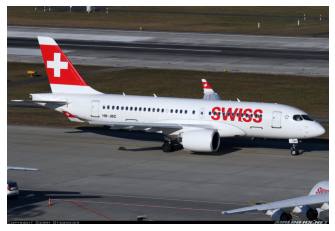

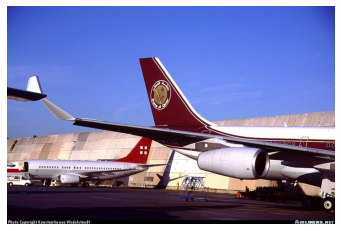

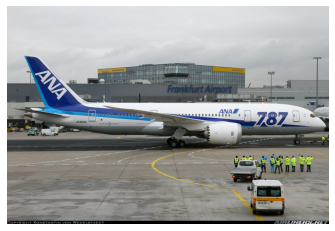

In [20]:
for i in random.sample(list(extra_test_img_dir),3):
    caption_images(i, 1)